In [33]:
# ============================================
#  Fuzzy Clustering - Store Product User
# ============================================

!pip install -q scikit-fuzzy plotly pandas numpy scikit-learn

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler

# ---------- 1. Load dataset ----------
df=pd.read_csv("dataset_with_recommendations.csv")
print(df.shape)
df.head()
print(df.columns)


(300, 14)
Index(['user', 'store', 'product', 'store_freshness', 'store_distance',
       'product_price', 'product_quality', 'availability_score',
       'user_weight_price', 'user_weight_quality', 'user_weight_freshness',
       'preferred_product', 'cluster_id', 'recommendation_score'],
      dtype='object')


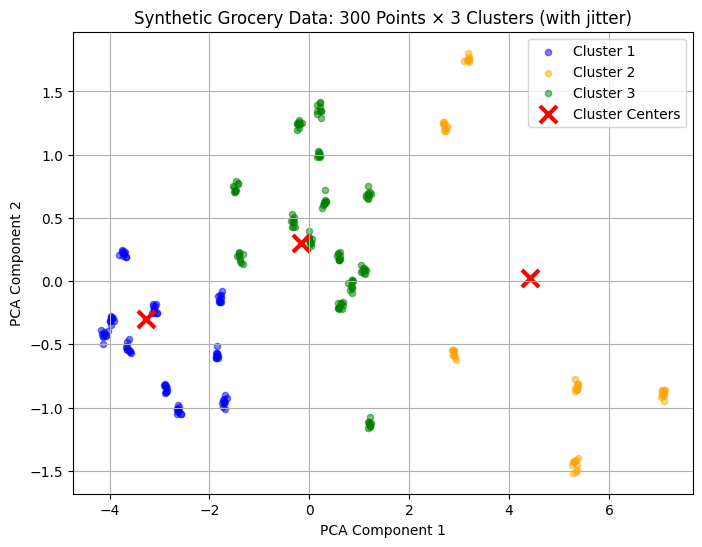

In [35]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ------------------------------------------------------------
#  Prepared data for visualization
# ------------------------------------------------------------
features = ['store_freshness','store_distance',
            'product_price','product_quality','availability_score']
X = df[features].values
labels = df['cluster_id'].values.astype(int)

# PCA: project 5D → 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add tiny jitter to separate overlapping points visually
np.random.seed(42)
jitter = np.random.normal(0, 0.03, X_pca.shape)   # adjust 0.03 for more/less spread
X_pca_jittered = X_pca + jitter

# Original 5D cluster centers
centers = np.array([
    [9, 2, 3, 9, 0.9],
    [6, 7, 7, 6, 0.5],
    [8, 4, 5, 8, 0.7]
])
centers_pca = pca.transform(centers)

# ------------------------------------------------------------
# Visualize like scikit-fuzzy: all points + red X centers
# ------------------------------------------------------------
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(figsize=(8,6))

for label in np.unique(labels):
    ax.scatter(
        X_pca_jittered[labels == label, 0],
        X_pca_jittered[labels == label, 1],
        s=20, alpha=0.5, color=colors[label],
        label=f'Cluster {label+1}'
    )

# Overlay cluster centers
ax.scatter(
    centers_pca[:,0], centers_pca[:,1],
    marker='x', color='red', s=150, linewidth=3, label='Cluster Centers'
)

# Match scikit-fuzzy aesthetics
ax.set_title(f'Synthetic Grocery Data: {len(df)} Points × 3 Clusters (with jitter)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.legend()
ax.grid(True)
plt.show()


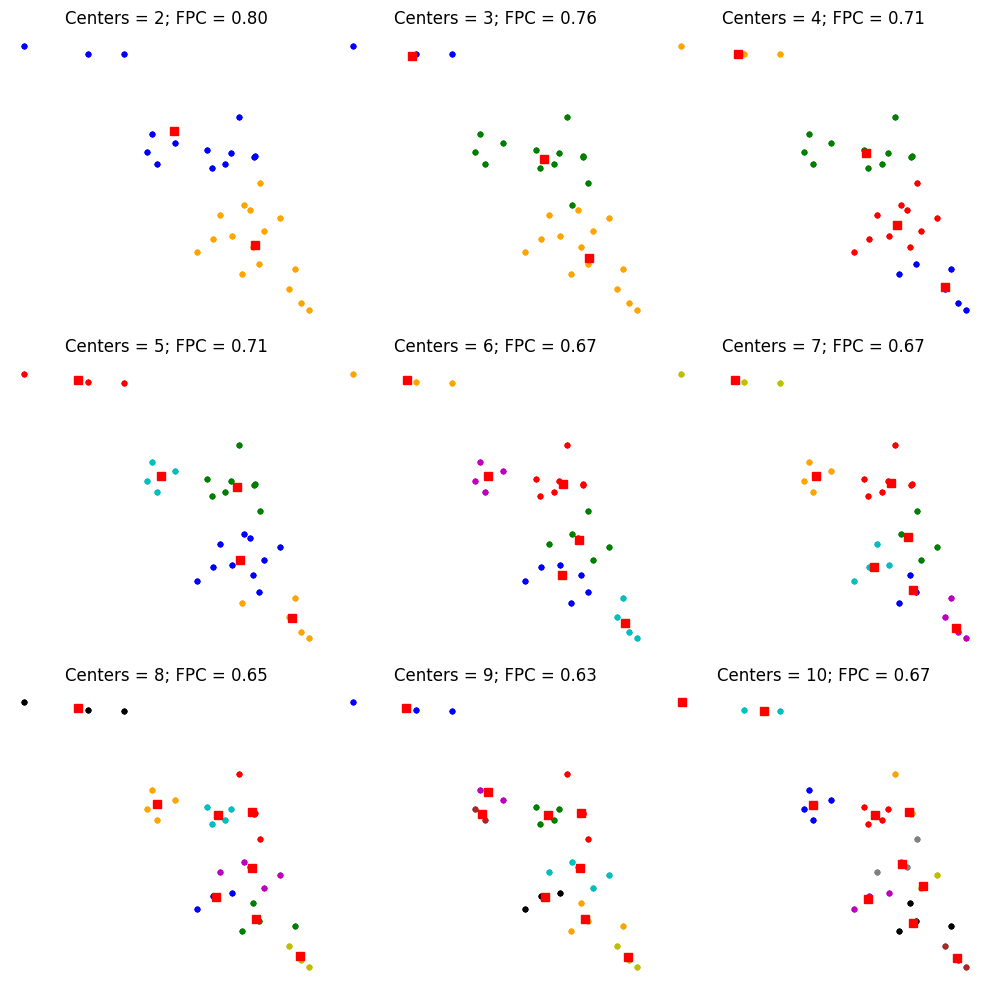

In [37]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# ------------------------------------------------------------
# Prepared data (numeric features only)
# ------------------------------------------------------------
features = ['store_freshness','store_distance',
            'product_price','product_quality','availability_score']
X = df[features].values.T   # transpose → shape = (features, samples)

# Reduce to 2D for visualization (optional)
xpts = X[0]
ypts = X[1]
alldata = np.vstack((xpts, ypts))

colors = ['b','orange','g','r','c','m','y','k','brown','gray']

# ------------------------------------------------------------
# Running fuzzy c-means with different cluster counts
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fpcs = []

for ncenters, ax in enumerate(axes.reshape(-1), 2):
    # Run fuzzy c-means
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, c=ncenters, m=2, error=0.005, maxiter=1000, init=None
    )

    fpcs.append(fpc)
    cluster_membership = np.argmax(u, axis=0)

    # Plot all data points by cluster color
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j % len(colors)], alpha=0.6)

    # Mark cluster centers
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title(f'Centers = {ncenters}; FPC = {fpc:.2f}')
    ax.axis('off')

fig.tight_layout()
plt.show()




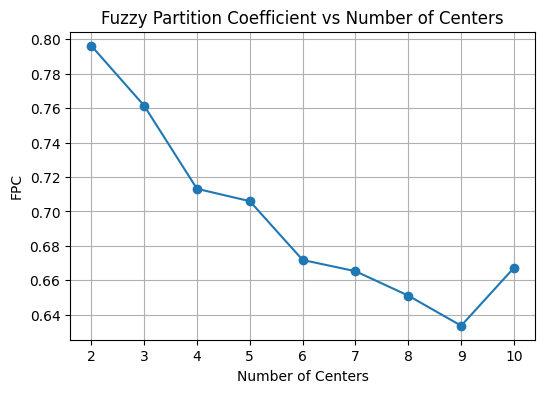

In [38]:
# ------------------------------------------------------------
# Plotting FPC values to choose optimal number of clusters
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(np.arange(2, 11), fpcs, marker='o')
plt.title('Fuzzy Partition Coefficient vs Number of Centers')
plt.xlabel('Number of Centers')
plt.ylabel('FPC')
plt.grid(True)
plt.show()

Fuzzy Partition Coefficient (FPC): 0.761


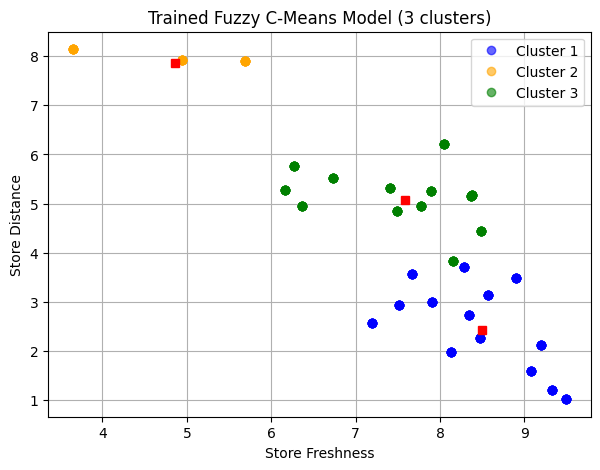

In [41]:


# ------------------------------------------------------------
# Picking two numeric grocery features
# ------------------------------------------------------------
features = ['store_freshness', 'store_distance']
alldata = df[features].values.T   # shape (2, N)

# ------------------------------------------------------------
# Fuzzy C-means clustering with 3 clusters
# ------------------------------------------------------------
cntr, u_orig, _, _, _, _, fpc = fuzz.cluster.cmeans(
    alldata, c=3, m=2, error=0.005, maxiter=1000, init=None
)

print(f"Fuzzy Partition Coefficient (FPC): {fpc:.3f}")

# ------------------------------------------------------------
# Plotting trained model exactly like scikit-fuzzy demo
# ------------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(7,5))
ax2.set_title('Trained Fuzzy C-Means Model (3 clusters)')

cluster_membership = np.argmax(u_orig, axis=0)
colors = ['b', 'orange', 'g', 'r', 'c', 'm']

for j in range(3):
    ax2.plot(alldata[0, cluster_membership == j],
             alldata[1, cluster_membership == j],
             'o', color=colors[j],
             alpha=0.6,
             label='Cluster ' + str(j+1))

# Mark fuzzy centers as red squares
for pt in cntr:
    ax2.plot(pt[0], pt[1], 'rs')

ax2.set_xlabel('Store Freshness')
ax2.set_ylabel('Store Distance')
ax2.legend()
ax2.grid(True)
plt.show()


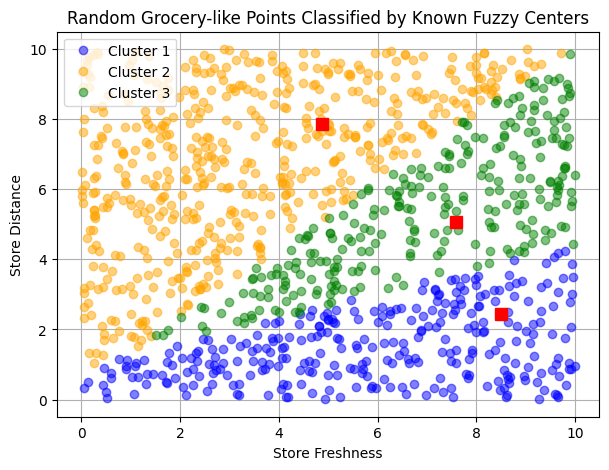

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# ------------------------------------------------------------
#  Generating uniformly sampled new data points
# ------------------------------------------------------------
# Create 1100 random grocery-like points in the range [0, 10]
# Each point has 2 features: store_freshness (x), store_distance (y)
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# ------------------------------------------------------------
#  Predicting cluster memberships using trained centers (cntr)
# ------------------------------------------------------------
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, m=2, error=0.005, maxiter=1000
)

# Convert fuzzy memberships to crisp clusters for visualization
cluster_membership = np.argmax(u, axis=0)

# ------------------------------------------------------------
# 3️⃣ Visualize classification of new points
# ------------------------------------------------------------
fig3, ax3 = plt.subplots(figsize=(7,5))
ax3.set_title('Random Grocery-like Points Classified by Known Fuzzy Centers')

colors = ['b','orange','g','r','c','m']

for j in range(3):
    ax3.plot(
        newdata[cluster_membership == j, 0],
        newdata[cluster_membership == j, 1],
        'o', alpha=0.5, color=colors[j], label='Cluster ' + str(j+1)
    )

# Mark known cluster centers from trained model
for pt in cntr:
    ax3.plot(pt[0], pt[1], 'rs', markersize=8)

ax3.set_xlabel('Store Freshness')
ax3.set_ylabel('Store Distance')
ax3.legend()
ax3.grid(True)
plt.show()


 **Note:**  
> The dataset and visualizations shown in this section are **synthetic** and generated only for **demonstration and experimentation** with fuzzy clustering methods.

> These data points do **not represent any real grocery or customer data**, and the results produced here (cluster centers, membership patterns, etc.) are **for illustration purposes only**.  


> This synthetic data will **not be used in the final presentation or report** — it is included solely to explain and visualize the fuzzy C-means clustering process on artificial examples.
